In [1]:
datadir_network = "../doc/zzli/data/LinkInfo/"
datafilename_network = "LinkAttributes.csv"
datafilepath_network = datadir_network + datafilename_network

datadir_proj = "../data/"
datafilename_proj = "Certainty.xlsx"
datafilepath_proj = datadir_proj + datafilename_proj

In [2]:
from itertools import combinations
import pandas as pd
import numpy as np

# Read in network information from sheet P0
# For now we only use the folloiwng columns in each sheet
network_cols_used = ['link','node_a','node_b','length','lanes_ab','speed_ab','fspd_ab','cap_ab','lanes_ba','speed_ba','fspd_ba','cap_ba']
df_network= pd.read_csv(datafilepath_network,usecols=network_cols_used).dropna(subset=['link'])

proj_cols_used = ['Link ID','ANODE','BNODE','A X_COORD','A Y_COORD','B X_COORD','B Y_COORD','Link Length(miles)','# of lanes-A','Capacity-A (veh/h)',
            'auto volume(2010)-A','AADT(2010)-A','Speed(mph)-A','VMT-A']
df_proj= pd.read_excel(datafilepath_proj, sheet_name='P0',usecols=proj_cols_used).dropna(subset=['Link ID'])
df_proj_unique = df_proj.drop_duplicates(subset=['Link ID'])


In [3]:
type(df_network)

pandas.core.frame.DataFrame

In [3]:
# Missing pairs of (ANODE, BNODE) from df_network
pairs_df_network = set(zip(df_network['node_a'], df_network['node_b']))
pairs_df_proj = set(zip(df_proj['ANODE'], df_proj['BNODE']))

missing_pairs = pairs_df_proj - pairs_df_network
print("Missing pairs in df_network:", missing_pairs)
print("Number of missing pairs of (ANOD, BNODE) = ", len(missing_pairs))
missing_pairs_list = list(missing_pairs)
missing_pairs_link_id = df_proj[df_proj[['ANODE', 'BNODE']].apply(tuple, axis=1).isin(missing_pairs_list)]['Link ID']
# print the Link ID's of missing pairs 
pd.set_option('display.max_rows', None)
# print("Missing pairs link ID: ", missing_pairs_link_id)



Missing pairs in df_network: {(7578.0, 7876.0), (6646.0, 6895.0), (5829.0, 6218.0), (8245.0, 8229.0), (81258.0, 11363.0), (12288.0, 80931.0), (17828.0, 17830.0), (11442.0, 11443.0), (17784.0, 17805.0), (14681.0, 80762.0), (8111.0, 7877.0), (9970.0, 10151.0), (17915.0, 17889.0), (81175.0, 9433.0), (80763.0, 14675.0), (13819.0, 80965.0), (10180.0, 80597.0), (5195.0, 5320.0), (11535.0, 11627.0), (13571.0, 19303.0), (16715.0, 16592.0), (8257.0, 8278.0), (10231.0, 10219.0), (14668.0, 80971.0), (8267.0, 81097.0), (80930.0, 11590.0), (11967.0, 11970.0), (11188.0, 11540.0), (80706.0, 10042.0), (11176.0, 11373.0), (17979.0, 17975.0), (19811.0, 5142.0), (16323.0, 16454.0), (17944.0, 17947.0), (7749.0, 8038.0), (80709.0, 10086.0), (6530.0, 6219.0), (13235.0, 80942.0), (7624.0, 6850.0), (11144.0, 81116.0), (16355.0, 15734.0), (17861.0, 17860.0), (5117.0, 5141.0), (17957.0, 17943.0), (12398.0, 80930.0), (13812.0, 80968.0), (10928.0, 11596.0), (80556.0, 5684.0), (80932.0, 12662.0), (80702.0, 10076.0

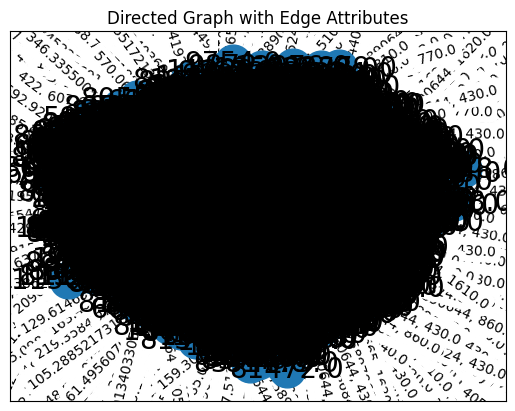

In [14]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# # Add nodes (nodes will be added automatically when adding edges)
# nodes = [1, 2, 3, 4, 5]
# G.add_nodes_from(nodes)

Anodes = df_network['node_a'].tolist
Bnodes = df_network['node_b'].tolist



# Add edges_ab with attributes

edges = [
    (row['node_a'], row['node_b'], {
        'length': row['length'], 
        'lanes': row['lanes_ab'], 
        'speed': row['speed_ab'], 
        'cap': row['cap_ab']
    })
    for _, row in df_network.iterrows()
]

 
# Add edges_ba only if lanes_ba != 0
edges += [
    (row['node_b'], row['node_a'], {
        'length': row['length'], 
        'lanes': row['lanes_ba'], 
        'speed': row['speed_ba'], 
        'cap': row['cap_ba']
    })
    for _, row in df_network.iterrows() if row['lanes_ba'] != 0
]

G.add_edges_from(edges)



import matplotlib.pyplot as plt

# Draw the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
edge_labels = {(u, v): f"{attr['length']}, {attr['lanes']}, {attr['speed']}, {attr['cap']}" for u, v, attr in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Directed Graph with Edge Attributes")
plt.show()

In [5]:
### Link lengths have discrapancies 


df_proj_del_missing = df_proj[~df_proj['Link ID'].isin(missing_pairs_link_id)]
df_proj_in_network = df_network[df_network['link'].isin(df_proj['Link ID'])]
df_proj_in_network = df_proj_in_network[~df_proj_in_network['link'].isin(missing_pairs_link_id)]


# print(df_proj_del_missing["Link Length(miles)"]*1609.34)
# print(df_proj_in_network['length'])

df_proj_del_missing.set_index('Link ID', inplace=True)
# len(df_proj_del_missing)
sorted_df_proj_del_missing = df_proj_del_missing.sort_index()

sorted_df_proj_in_network = df_proj_in_network.sort_index()

filtered_df_proj_del_missing = sorted_df_proj_del_missing.loc[sorted_df_proj_del_missing.index.isin(sorted_df_proj_in_network.index)]
filtered_df_proj_in_network = sorted_df_proj_in_network.loc[sorted_df_proj_in_network.index.isin(sorted_df_proj_del_missing.index)]


length_difference = filtered_df_proj_del_missing["Link Length(miles)"]*1609.34 - sorted_df_proj_in_network['length']



# print(sorted_df_proj_del_missing["Link Length(miles)"]*1609.34, sorted_df_proj_in_network['length'])

In [14]:
# Convert arrays to sets
set_network_a = set(df_network['node_a'])
set_proj_a = set(df_proj['ANODE'])

set_network_b = set(df_network['node_b'])
set_proj_b = set(df_proj['BNODE'])

# # Check if set2 is a subset of set1
is_subset_a = set_proj_a.issubset(set_network_a)
is_subset_b = set_proj_b.issubset(set_network_b)

node_b_difference = set_proj_b - set_network_b


### All project node A's are included in the general network, but 40 project node B's are not. 
## For now, we delete links with these 40 node B's from the project, but we should try to incorporate them later on

print(f"All A nodes in project are in the general network: {is_subset_a}")
print(f"All B nodes in project are in the general network: {is_subset_b}")
# print(node_b_difference)
print(len(node_b_difference))


All A nodes in project are in the general network: True
All B nodes in project are in the general network: False
40
